## Set-up

Install

In [22]:
# Create requirements.txt
# !pip install kaggle
# Make sure correct graphistry is installed

100%|███████████████████████████████████████▊| 177M/178M [00:13<00:00, 14.5MB/s]
100%|████████████████████████████████████████| 178M/178M [00:13<00:00, 14.2MB/s]


Methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cudf
import cugraph
from tqdm import tqdm
# Add cuda check

### Data Wrangling and Featurization

#### Find a (raw) rich dataset in fraud/cybersecurity/recommendation/supply chain with some notion of events & entities (logs, orders / bill of materials, ..), pull it in, clean and load it. 

[Kaggle: Fraudulent transactions data for a financial company](https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data)

In [7]:
# Load data
# !kaggle datasets download -d chitwanmanchanda/fraudulent-transactions-data -p data --unzip
gdf = cudf.read_csv("data/Fraud.csv")

# Parse out node type and index from src/dst names
gdf.loc[:,"typeOrig"] = gdf.nameOrig.str[0]
gdf.loc[:,"typeDest"] = gdf.nameDest.str[0]
gdf.loc[:,"numOrig"] = gdf.nameOrig.str[1:].astype(int)
gdf.loc[:,"numDest"] = gdf.nameDest.str[1:].astype(int)
G = cugraph.MultiDiGraph()
G.from_cudf_edgelist(gdf, source='nameOrig', destination='nameDest', renumber=True)

In [10]:
%%time
def directed_density(V:int, E:int) -> float:
    return E/(V*(V-1))

v, e = G.number_of_nodes(), G.number_of_edges()
print(f"Nodes:\t\t\t{v:,}")
print(f"Edges:\t\t\t{e:,}")
print(f"Density:\t\t{directed_density(V=v, E=e)}")
print()
print(f"Is directed?\t\t{G.is_directed()}")
print(f"Is multigraph?\t\t{G.is_multigraph()}")
print(f"Is renumbered?\t\t{G.is_renumbered()}")
print(f"Self loops?\t\t{G.has_self_loop()}")
print(f"Isolated vertices?\t{bool(G.has_isolated_vertices())}")
print()

Nodes:			9,066,982
Edges:			6,362,620
Density:		7.739457630800124e-08

Is directed?		True
Is multigraph?		True
Is renumbered?		True
Self loops?		False
Isolated vertices?	False

CPU times: user 89 µs, sys: 25 µs, total: 114 µs
Wall time: 73.7 µs


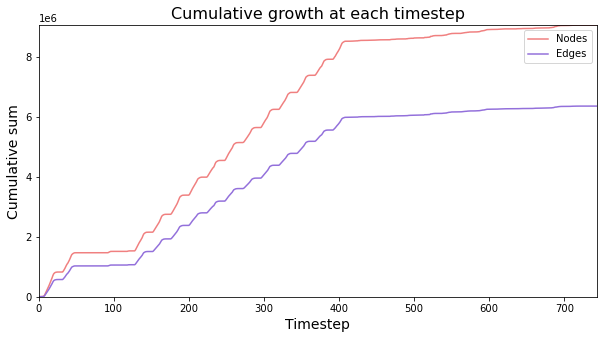

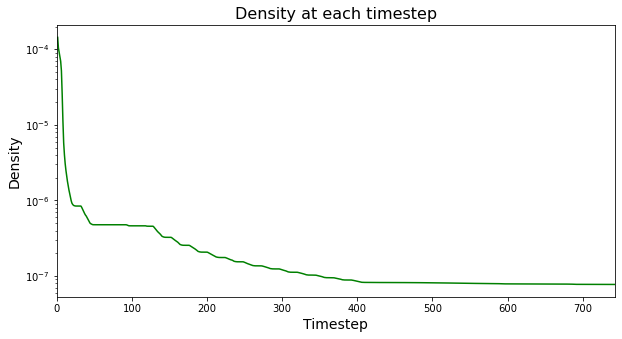

In [185]:
%%time
# Nodes Edges at each timestep
num_nodes, num_edges, density = [], [], []
timestep_cumsum = []
x = gdf.step.unique().values.get()
for timestep in tqdm(x, total=len(x), desc="Calculating graph attributes..."):
    timestep_cumsum.append(timestep)
    temp_gdf = gdf[gdf.step.isin(timestep_cumsum)]
    tG = cugraph.MultiDiGraph()
    tG.from_cudf_edgelist(
        temp_gdf, source="numOrig", destination="numDest"
    )
    tv, te = tG.number_of_nodes(), tG.number_of_edges()
    num_nodes.append(tv)
    num_edges.append(te)
    density.append(directed_density(V=tv, E=te))
    
# Node/Edges count plot
plt.figure(figsize=(10, 5))
plt.title("Cumulative growth at each timestep", fontsize=16)
plt.ylabel("Cumulative sum", fontsize=14)
plt.xlabel("Timestep", fontsize=14)
plt.ylim(0, max(num_nodes) + 1000)
plt.xlim(0, max(x))
plt.plot(x, num_nodes, color="lightcoral", label="Nodes")
plt.plot(x, num_edges, color="mediumpurple", label="Edges")
plt.legend()
plt.show()

# Density plot
plt.figure(figsize=(10, 5))
plt.title("Density at each timestep", fontsize=16)
plt.ylabel("Density", fontsize=14)
plt.xlabel("Timestep", fontsize=14)
plt.yscale('log')
plt.xlim(0, max(x))
plt.plot(x, density, color="green")
plt.show()

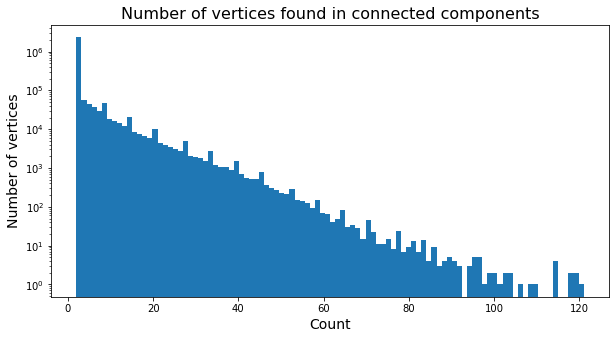

In [186]:
# Connected components
cc = cugraph.connected_components(cugraph.Graph(G, directed=True))
plt.figure(figsize=(10, 5))
plt.title("Number of vertices found in connected components", fontsize=16)
plt.ylabel("Number of vertices", fontsize=14)
plt.xlabel("Count", fontsize=14)
plt.hist(cc.groupby("labels")["vertex"].count().values.get(), bins=100)
plt.yscale('log')
plt.show()

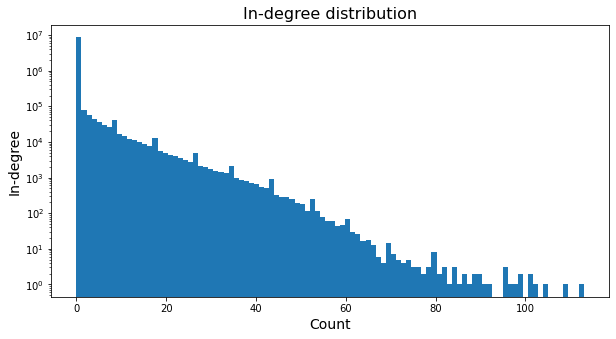

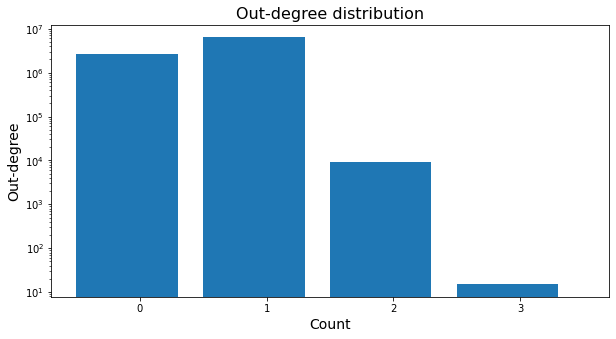

In [21]:
# Degree distribution
# Total
deg = G.degrees()
deg.loc[:,"degree"] = deg.in_degree + deg.out_degree
# In-degree
plt.figure(figsize=(10, 5))
plt.title("In-degree distribution", fontsize=16)
plt.ylabel("In-degree", fontsize=14)
plt.xlabel("Count", fontsize=14)
plt.hist(deg.in_degree.values.get(), bins=100)
plt.yscale('log')
plt.show()
# Out-degree
plt.figure(figsize=(10, 5))
plt.title("Out-degree distribution", fontsize=16)
plt.ylabel("Out-degree", fontsize=14)
plt.xlabel("Count", fontsize=14)
plt.hist(deg.out_degree.values.get(),width=0.8, bins=np.arange(5) - 0.5)
plt.xticks(range(4))
plt.yscale('log')
plt.show()

#### What are good columns for features? Why?

In [115]:
gdf.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,typeOrig,typeDest,numOrig,numDest
1092887,130,TRANSFER,445346.96,C1792226100,0.00,0.00,C56074101,10047646.11,10492993.07,0,0,C,C,1792226100,56074101
111998,11,PAYMENT,4344.46,C2115454088,0.00,0.00,M1474441511,0.00,0.00,0,0,C,M,2115454088,1474441511
1648121,158,CASH_IN,269976.09,C105618279,1433863.67,1703839.75,C294181944,877676.83,729702.84,0,0,C,C,105618279,294181944
1264666,134,PAYMENT,25246.17,C117467689,0.00,0.00,M1171164395,0.00,0.00,0,0,C,M,117467689,1171164395
3495188,259,PAYMENT,1756.13,C1148076152,15901.00,14144.87,M2077979505,0.00,0.00,0,0,C,M,1148076152,2077979505


Node features:

- `node_type`: Whether a node is a customer or merchant.

Edge features:

- `type`: Type of transaction. It's relevant because fraudulent transactions may occur more frequently in certain classes than others.
- `amount`: The amount of money transferred between source and destination nodes in the transaction dataset. There are often specific limits that trigger fraud flags for a given transaction size. 

There is likely strong correlations between the balance variables so we will see if a pair will also be incorporated into edge features.

In [116]:
# Unique values in each column
# step - there are 743 unique steps (roughly one for each hour across 30 days)
# type - there are 5 unique transaction types
# isFraud/isFlaggedFraud - indicator target variables
# amount/balance - continuous numerical values
# typeOrig - all source nodes are customers
# typeDest - destination nodes can be customers or merchants
gdf.nunique()

# NOTE That unqiue values in names != indexes, so the same number might have been used for both customers and merchants

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
typeOrig                1
typeDest                2
numOrig           6353307
numDest           2721804
dtype: int64

On first look, there are no missing values in the dataframe. However, merchants do not have balance information available, so it should be confirmed in the data that their associated balances are equal to 0.

In [97]:
# Count missing
gdf.isna().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
renumbered_src    0
renumbered_dst    0
dtype: int64

Merchant node balances have been set to 0.

In [123]:
# Check out dataframe where there are destination merchant nodes
m_gdf = gdf.copy()[gdf.typeDest=="M"]
m_gdf[["oldbalanceDest","newbalanceDest"]].nunique()

oldbalanceDest    1
newbalanceDest    1
dtype: int64

Let's now check out the distributions and correlations between each of the columns!

In [23]:
# Univariate distributions

In [ ]:
# Bivariate distributions

In [ ]:
# Multivariate distributions

#### Perform feature engineering. Be ready to discuss data quality, insights, & challenges.

What are possible insights?
Is the dataset balanced?
What distributions likely model the different columns?
Is there a target(s)? Why are they important?
Descriptive statistics?

In [21]:
# Target value #1 -- Imbalanced
gdf.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int32

In [ ]:
# Encoding schemes
# LabelBinarizer --> node_type, edge_type
# Normalize --> amount/balances
# OR
# UMAP?

## GNN

Turn the dataset into a GNN model - Popular ones include GCN, GAT, RGCN

Depending on the dataset, fit one (or more) of the following models:
- **Link Prediction**
- **Edge Classification**

How does the model perform? How would you improve it with more time?

#### GNN Visualization $\rightarrow$ see `viz.ipynb` notebook

## Extra credit

Can you wrap the above in basic MLOps? 

How about model explainability? 